### 🧩 Imports

Import all the necessary libraries:
- `json` for reading/writing JSON files.
- `pandas` and `numpy` for data manipulation.
- `random` for generating random synthetic data.
- `IsolationForest` from `sklearn` for anomaly detection.
- `joblib` for saving the trained model.

In [16]:
import json
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
import random
import joblib

### 📊 Generate Dataset

Create synthetic "normal" network traffic data to train an anomaly detection model. Each sample includes:

- `src_port`: randomly selected from common service ports.
- `dst_port`: a random high port number.
- `packet_size`: typical packet sizes.
- `duration_ms`: duration of the communication.
- `protocol`: randomly selected between TCP and UDP.

This data is saved to `training_data.json` for future use.

In [17]:
COMMON_PORTS = [80, 443, 22, 8080]

def generate_normal_data():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(100, 1500),
        "duration_ms": random.randint(50, 500),
        "protocol": random.choice(["TCP", "UDP"])
    }

dataset = [generate_normal_data() for _ in range(1000)]

with open("../dataset/training_data.json", "w") as f:
    json.dump(dataset, f, indent=2)


In [18]:
with open("E:/uni/cyberSecurity/project/anomaly-detection-project-rsh/dataset/training_data.json") as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
display(df)

,src_port,dst_port,packet_size,duration_ms,protocol
0,80,22199,1151,53,TCP
1,8080,17322,1422,264,TCP
2,443,39581,1119,416,UDP
3,22,14428,1343,107,UDP
4,443,4034,612,94,TCP
...,...,...,...,...,...
995,8080,37047,839,315,UDP
996,443,17719,835,78,UDP
997,80,11657,1167,282,TCP
998,22,10412,865,130,TCP


### 🧼 Preprocessing Function

Machine learning models like Isolation Forest require **numerical input only**. Any categorical variables, such as the `protocol` column (`TCP`, `UDP`), must be converted into numbers.

We handle this with **one-hot encoding**, using `pd.get_dummies`.

#### 🛠️ Preprocessing Steps:

1. **Identify categorical columns**:
   - In our case, the `protocol` column is categorical (`TCP`, `UDP`).

2. **Use `pd.get_dummies`**:
   - This creates a new binary column for each category.
   - For instance:
     ```
     protocol
     ---------
     TCP   →   protocol_UDP = 0
     UDP   →   protocol_UDP = 1
     ```
   - Setting `drop_first=True` prevents multicollinearity by dropping the first category (`TCP` here), as it can be inferred from the others.

3. **Return a DataFrame with all numerical values**:
   - This is ready for model input.

> ✅ This preprocessing is essential to avoid errors during training and ensure the model can learn from categorical variables.

In [19]:
def preprocess_data(df):
    # One-hot encode the 'protocol' column
    df_processed = pd.get_dummies(df, columns=['protocol'], drop_first=True)
    # Convert to numpy array for model input
    return np.array(df_processed)

### 🤖 Train Isolation Forest

The `IsolationForest` algorithm is an unsupervised model used to detect anomalies. It isolates observations by randomly selecting features and splitting values.

- `n_estimators=100`: number of trees in the forest.
- `contamination=0.01`: assumes 1% of the data is anomalous.
- `random_state=42`: ensures reproducibility.

The model is trained on the preprocessed numerical dataset.

In [20]:
model = IsolationForest(contamination=0.1, random_state=42)
X = preprocess_data(df)
model.fit(X)

IsolationForest(contamination=0.1, random_state=42)

### 💾 Save Trained Model

Save the trained model using `joblib`, which allows for efficient serialization and deserialization. This saved model can be reused later for inference or deployment.


In [21]:
joblib.dump(model, "anomaly_model.joblib")

['anomaly_model.joblib']

# predict data

In [23]:
model.predict(X)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,
       -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

# Visualize Normal and Anomalous Points with PCA

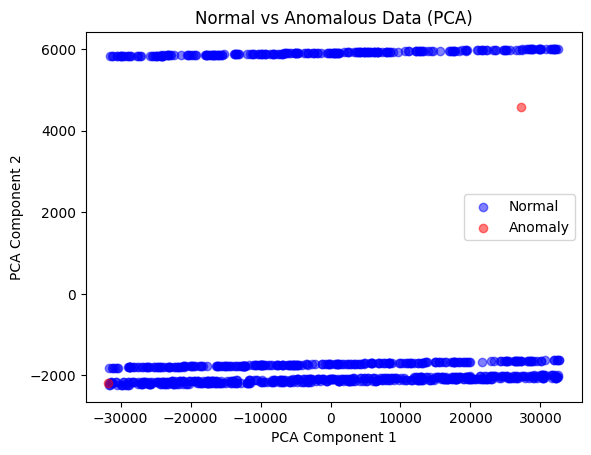

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate some anomalous data for visualization
anomaly_data = [
    {"src_port": 6666, "dst_port": 60000, "packet_size": 1500, "duration_ms": 5000, "protocol": "UNKNOWN"},
    {"src_port": 80, "dst_port": 1024, "packet_size": 5000, "duration_ms": 100, "protocol": "TCP"}
]
df_anomaly = pd.DataFrame(anomaly_data)
X_anomaly = preprocess_data(df_anomaly)

# Combine normal and anomalous data
X_all = np.vstack([X, X_anomaly])
labels = np.array([1] * len(X) + [-1] * len(X_anomaly))

# Apply PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)

# Plot
plt.scatter(X_2d[labels == 1, 0], X_2d[labels == 1, 1], c='blue', label='Normal', alpha=0.5)
plt.scatter(X_2d[labels == -1, 0], X_2d[labels == -1, 1], c='red', label='Anomaly', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Normal vs Anomalous Data (PCA)')
plt.legend()
plt.show()

This code:
    
    Generates sample anomalous data.
    Combines it with normal data.
    Uses PCA to reduce to 2D.
    Plots normal (blue) and anomalous (red) points.